# Vehicle Detection

In this part, we will learn how to make a model for object detection. Object Detection is one of many task in deep learning regarding image input. Object detection can help us to find particular object inside an image and also know what type of that object is. We will use vehicle detection as study case of object detection

## Import Library

In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import requests
import random
import numpy as np
import kagglehub

np.random.seed(42)

## Import Data

The data that we used in from Kaggle. So, make sure you have enough storage to download it. It's around 100MB data. But, rest assured, as long as you use Google Colab or Kaggle, it will be okay.

In [2]:
cars_detection_path = kagglehub.dataset_download('abdallahwagih/cars-detection')

print('Data source import complete.')

100%|██████████| 38.2M/38.2M [00:00<00:00, 95.5MB/s]

Extracting files...


Data source import complete.


In [3]:
## Do this to set the dataset dir according to your environment. This code use to set the collab environment

import shutil
from pathlib import Path

# Define the source and destination folders
source_folder = Path(f"{cars_detection_path}/Cars Detection")
destination_folder = Path("/content/Cars Detection")

# Create the destination folder if it doesn't exist
destination_folder.mkdir(parents=True, exist_ok=True)

# Move each item from source to destination
for item in source_folder.iterdir():
    shutil.move(str(item), str(destination_folder))

In [4]:
cars_detection_path = "/content/Cars Detection"

## Define Function

There's three functions:
- `yolo2bbox` for processing bboxes number into x and y coordinates.
- `plot_box` for drawing the bboxes for each image.
- `plot` for process random image with `yolo2bbox` and `plot_box`, then show the processed image result.

In [5]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [6]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [7]:
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

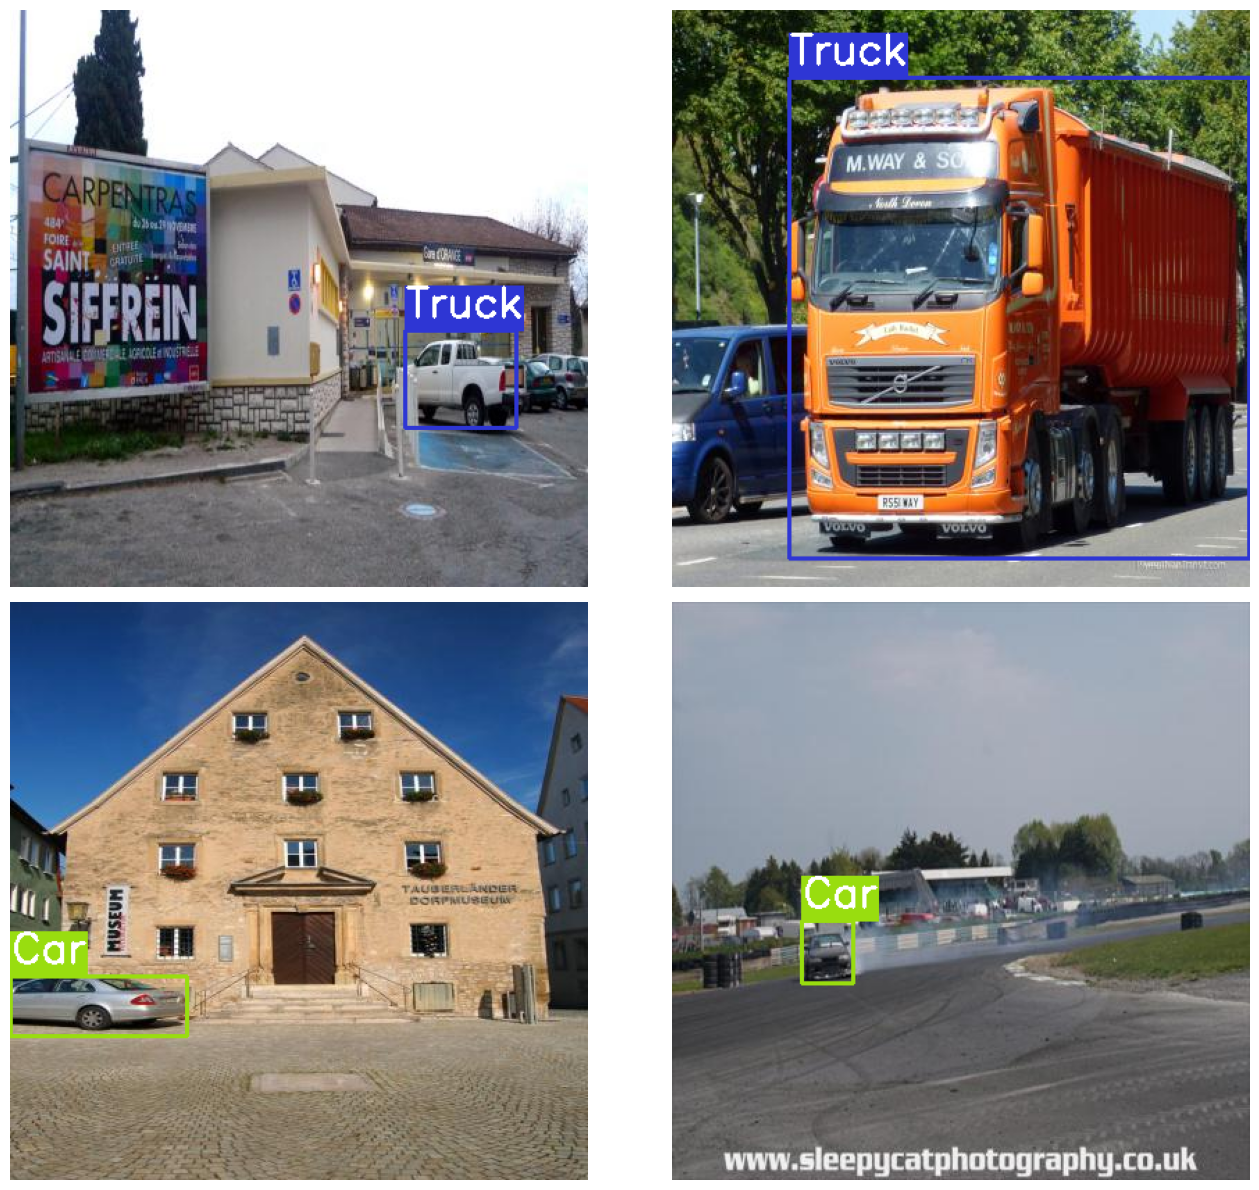

In [8]:
plot(image_paths=f'{cars_detection_path}/train/images/*',
    label_paths=f'{cars_detection_path}/train/labels/*',
    num_samples=4,
)

## YOLOV8

We use YOLOV8, one of the best deep learning model for image use case (classification or detection). Let's use library `ultralytics`, so we can use YOLOV8 model for vehicle type detection

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 21.3 MB/s eta 0:00:00


In [ ]:
import os
from ultralytics import YOLO

# defining YOLO model. We will use YOLO V8 nano model. Why the small one? Because we want to make sure it will be fast enough to train it and doesn't take up resource too much.
model = YOLO("yolov8n.yaml")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# This part we will train the model. With T4 from Google Colab, it is around 30-40 minutes.

from ultralytics import YOLO
results = model.train(data=f"{cars_detection_path}/data.yaml", epochs=100)  # train the model

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/Cars Detection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 58.9MB/s]


AMP: checks passed ✅


train: Scanning /content/Cars Detection/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:00<00:00, 1611.62it/s]

train: New cache created: /content/Cars Detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/Cars Detection/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 526.13it/s]

val: New cache created: /content/Cars Detection/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.29G      3.235      4.403      4.213         48        640: 100%|██████████| 55/55 [00:20<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        250        454    0.00228      0.479    0.00253    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.19G      3.222       4.22      3.989         59        640: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]

                   all        250        454    0.00274      0.559    0.00482    0.00143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.26G      3.082      4.102      3.662         47        640: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

                   all        250        454       0.01      0.215    0.00838    0.00196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.27G      2.865      3.999      3.402         46        640: 100%|██████████| 55/55 [00:19<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        250        454    0.00412      0.174    0.00527    0.00135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.16G      2.679       3.88       3.22         43        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

                   all        250        454     0.0358     0.0264     0.0194     0.0064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.16G      2.532      3.787      3.049         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        250        454     0.0126      0.527     0.0378     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.16G      2.421      3.667      2.926         60        640: 100%|██████████| 55/55 [00:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        250        454      0.031      0.391     0.0621     0.0237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.26G      2.299      3.573      2.825         50        640: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        250        454     0.0293     0.0513     0.0263    0.00898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.18G      2.146      3.478      2.694         41        640: 100%|██████████| 55/55 [00:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

                   all        250        454      0.446     0.0584     0.0846     0.0348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.16G        2.1       3.39      2.625         55        640: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

                   all        250        454     0.0569      0.175     0.0615      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.18G      2.046      3.291      2.548         54        640: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

                   all        250        454     0.0648      0.154     0.0734     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.26G      1.957      3.299      2.514         41        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]

                   all        250        454      0.303     0.0444     0.0652     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.16G      1.962      3.195      2.474         53        640: 100%|██████████| 55/55 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        250        454      0.324      0.116     0.0897     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.17G      1.889      3.114      2.426         45        640: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

                   all        250        454       0.16     0.0896     0.0973     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.14G      1.893      3.093      2.384         47        640: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]

                   all        250        454       0.17      0.142      0.102     0.0481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.26G      1.837       3.02      2.357         48        640: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

                   all        250        454      0.165      0.222      0.128     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.16G      1.786      2.945      2.288         47        640: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        250        454      0.167      0.213      0.141     0.0682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.18G      1.806      2.886      2.293         54        640: 100%|██████████| 55/55 [00:16<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        250        454      0.184      0.224      0.164     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.16G      1.773      2.876      2.273         60        640: 100%|██████████| 55/55 [00:15<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

                   all        250        454      0.212      0.231      0.159     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.24G      1.728      2.794      2.226         56        640: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

                   all        250        454      0.143      0.216      0.157     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.18G      1.725       2.82      2.236         46        640: 100%|██████████| 55/55 [00:16<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

                   all        250        454       0.29      0.269      0.206      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.16G      1.696      2.726      2.208         47        640: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

                   all        250        454      0.186      0.255      0.171       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.15G      1.692      2.716      2.184         56        640: 100%|██████████| 55/55 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        250        454      0.243      0.286      0.239      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.26G      1.665      2.684      2.158         44        640: 100%|██████████| 55/55 [00:15<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        250        454      0.284        0.3      0.219      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.16G      1.629      2.606      2.128         46        640: 100%|██████████| 55/55 [00:17<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.50it/s]

                   all        250        454      0.281      0.301      0.225       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.16G      1.626      2.616      2.127         51        640: 100%|██████████| 55/55 [00:16<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        250        454      0.243      0.315       0.25      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.19G      1.621       2.55      2.111         43        640: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250        454      0.284      0.244       0.23      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.26G      1.591      2.506      2.091         66        640: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

                   all        250        454      0.306      0.357      0.273      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.16G      1.594      2.467      2.084         38        640: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

                   all        250        454      0.294      0.281      0.245       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.16G      1.577      2.463      2.086         51        640: 100%|██████████| 55/55 [00:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        250        454      0.243      0.333      0.219      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.17G       1.56      2.434      2.048         58        640: 100%|██████████| 55/55 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]

                   all        250        454      0.356      0.366      0.318      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.24G      1.557      2.394       2.02         61        640: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.50it/s]

                   all        250        454      0.333      0.324      0.277      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.16G      1.533      2.301      2.013         62        640: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

                   all        250        454      0.371      0.398      0.284      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.16G      1.521      2.329      2.018         40        640: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.40it/s]

                   all        250        454      0.336      0.329       0.27      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.16G      1.491      2.313      1.986         46        640: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        250        454      0.335      0.349      0.287      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.24G      1.509       2.34      2.008         40        640: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        250        454      0.285      0.341      0.287      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.18G      1.507      2.285      1.988         53        640: 100%|██████████| 55/55 [00:16<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        250        454      0.333      0.365      0.324      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.16G      1.442      2.228      1.953         69        640: 100%|██████████| 55/55 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        250        454      0.426      0.316      0.302      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.16G      1.485      2.256      1.964         55        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        250        454      0.361      0.376      0.311      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.26G      1.439      2.228       1.93         42        640: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        250        454      0.296      0.401      0.296      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.19G      1.451      2.192      1.926         37        640: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]

                   all        250        454      0.445      0.339      0.329      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.16G      1.455      2.213      1.939         48        640: 100%|██████████| 55/55 [00:16<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all        250        454      0.352      0.373      0.338      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.14G      1.456      2.199      1.928         43        640: 100%|██████████| 55/55 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]

                   all        250        454      0.381      0.299      0.306       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.26G      1.406      2.116      1.904         58        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]

                   all        250        454      0.287      0.415      0.313      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.18G      1.408      2.121       1.91         35        640: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

                   all        250        454      0.331      0.359      0.329       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.16G      1.413      2.119      1.914         50        640: 100%|██████████| 55/55 [00:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        250        454      0.372      0.409       0.36      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.16G      1.381      2.072      1.879         48        640: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        250        454      0.363      0.425      0.386      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.26G      1.388      2.071      1.881         32        640: 100%|██████████| 55/55 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        250        454      0.275      0.442      0.236      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.18G      1.402      2.083      1.886         73        640: 100%|██████████| 55/55 [00:15<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

                   all        250        454      0.333      0.393      0.362      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.18G      1.374      2.065      1.866         44        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.51it/s]

                   all        250        454      0.322      0.374       0.27      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.15G      1.328      1.967      1.816         47        640: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

                   all        250        454      0.497       0.36      0.406      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.26G      1.366      1.993      1.843         54        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


                   all        250        454      0.433      0.373      0.358      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.18G      1.318      1.951      1.821         45        640: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

                   all        250        454      0.381      0.421      0.365      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.16G      1.314      1.944      1.818         51        640: 100%|██████████| 55/55 [00:17<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

                   all        250        454      0.565      0.372      0.418      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.16G      1.325      1.953      1.797         49        640: 100%|██████████| 55/55 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]

                   all        250        454      0.518        0.4      0.409      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.22G      1.287      1.889      1.785         52        640: 100%|██████████| 55/55 [00:16<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        250        454      0.358      0.429      0.336      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.18G      1.303      1.918        1.8         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]

                   all        250        454      0.479      0.391      0.416      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.15G      1.284      1.928      1.781         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

                   all        250        454      0.486      0.363      0.397      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.18G      1.314      1.889      1.795         66        640: 100%|██████████| 55/55 [00:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

                   all        250        454      0.504      0.407      0.416      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.26G      1.295      1.877      1.762         38        640: 100%|██████████| 55/55 [00:16<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

                   all        250        454      0.495      0.379      0.389       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.19G      1.275      1.861       1.76         51        640: 100%|██████████| 55/55 [00:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all        250        454      0.532      0.373      0.407      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.18G      1.297       1.86      1.775         64        640: 100%|██████████| 55/55 [00:15<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        250        454      0.403      0.408      0.343      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.16G      1.279      1.864      1.768         35        640: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.71it/s]

                   all        250        454      0.495      0.376       0.41      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.27G      1.268      1.807      1.749         48        640: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]

                   all        250        454        0.4      0.405      0.416      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.18G      1.253      1.778      1.729         59        640: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

                   all        250        454      0.576      0.413      0.445      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.19G      1.251      1.753      1.727         54        640: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

                   all        250        454      0.482       0.45      0.446      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.18G      1.236      1.753      1.729         52        640: 100%|██████████| 55/55 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]

                   all        250        454      0.433      0.444      0.414      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.26G       1.25      1.759      1.718         73        640: 100%|██████████| 55/55 [00:15<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        250        454        0.6      0.407       0.43      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.16G      1.223      1.743      1.708         70        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all        250        454      0.597       0.44       0.45      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.15G      1.214      1.735      1.708         48        640: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.51it/s]

                   all        250        454      0.491      0.474      0.444        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.16G      1.215      1.706      1.697         42        640: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

                   all        250        454      0.455      0.478       0.46       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.26G        1.2      1.673      1.686         40        640: 100%|██████████| 55/55 [00:16<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250        454      0.499      0.443      0.448      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.16G      1.225      1.688      1.698         59        640: 100%|██████████| 55/55 [00:19<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        250        454      0.603      0.384      0.458        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.14G      1.198      1.673       1.68         40        640: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        250        454      0.528      0.393      0.446        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.15G      1.178      1.652       1.67         33        640: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

                   all        250        454      0.509       0.43      0.458      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.24G      1.202       1.61      1.691         83        640: 100%|██████████| 55/55 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

                   all        250        454      0.554      0.449      0.475      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.18G      1.184      1.608      1.673         59        640: 100%|██████████| 55/55 [00:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        250        454      0.573      0.377      0.447      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.15G      1.154      1.562      1.638         50        640: 100%|██████████| 55/55 [00:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

                   all        250        454      0.489      0.473      0.467      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.17G      1.157      1.569      1.637         71        640: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

                   all        250        454      0.589      0.432      0.454      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.26G      1.151      1.572      1.644         54        640: 100%|██████████| 55/55 [00:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

                   all        250        454      0.455      0.504      0.473      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.18G       1.17      1.596      1.642         45        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        250        454      0.512      0.447      0.464      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.18G      1.164      1.566      1.636         49        640: 100%|██████████| 55/55 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        250        454      0.579      0.461      0.469      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.16G      1.125      1.528      1.615         62        640: 100%|██████████| 55/55 [00:21<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        250        454      0.544      0.424      0.452      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.24G      1.155      1.558      1.637         63        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

                   all        250        454      0.494      0.452      0.451      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.19G      1.145      1.535      1.626         48        640: 100%|██████████| 55/55 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250        454      0.488      0.508      0.468      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.16G      1.117      1.479      1.605         35        640: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        250        454      0.506      0.469      0.469      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.18G      1.116      1.466       1.61         42        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        250        454      0.568      0.395      0.459      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.26G      1.104      1.468      1.601         49        640: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

                   all        250        454      0.503      0.472      0.456        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.16G      1.109      1.508      1.595         40        640: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

                   all        250        454      0.614      0.437      0.482      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.17G      1.128       1.51      1.624         52        640: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        250        454      0.464      0.524      0.475       0.32


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.14G      1.017      1.275      1.545         23        640: 100%|██████████| 55/55 [00:18<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        250        454      0.527      0.441       0.46      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.22G      0.984      1.203      1.528         20        640: 100%|██████████| 55/55 [00:15<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        250        454      0.533       0.48      0.477      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.16G     0.9613      1.176      1.476         24        640: 100%|██████████| 55/55 [00:16<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

                   all        250        454      0.514      0.493       0.49      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.16G     0.9563      1.159      1.489         28        640: 100%|██████████| 55/55 [00:15<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        250        454       0.49      0.507      0.478      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.15G     0.9404      1.122      1.484         24        640: 100%|██████████| 55/55 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        250        454      0.555      0.495      0.481      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.22G     0.9493      1.122      1.481         21        640: 100%|██████████| 55/55 [00:15<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250        454      0.535      0.495      0.484      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.14G     0.9248      1.101      1.461         20        640: 100%|██████████| 55/55 [00:16<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        250        454      0.617       0.44      0.473      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.15G     0.9082      1.078       1.44         28        640: 100%|██████████| 55/55 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        250        454      0.527       0.49      0.476      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.14G     0.9286       1.07       1.46         20        640: 100%|██████████| 55/55 [00:16<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        250        454      0.545      0.497      0.479      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.22G     0.9034      1.055      1.435         21        640: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]

                   all        250        454      0.561      0.491      0.477      0.335



100 epochs completed in 0.584 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


                   all        250        454      0.514      0.492       0.49      0.343
             Ambulance         50         64      0.651      0.759      0.764       0.61
                   Bus         30         46      0.644      0.565      0.567      0.483
                   Car         90        238      0.486      0.345      0.339      0.215
            Motorcycle         42         46      0.485      0.492      0.525      0.258
                 Truck         38         60      0.306        0.3      0.255      0.147
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/train


## Model Evaluation

Evaluation step after training step is a necessary one. We must know model performance, so we can evaluate and improve even further if model's performance not to our satisfication.

In [12]:
results = model.val()

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Cars Detection/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


                   all        250        454      0.514      0.493       0.49      0.342
             Ambulance         50         64      0.652       0.76      0.764      0.609
                   Bus         30         46      0.643      0.565      0.567      0.483
                   Car         90        238      0.485      0.345      0.337      0.215
            Motorcycle         42         46      0.486      0.493      0.524      0.257
                 Truck         38         60      0.306        0.3      0.255      0.147
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train2


In [13]:
results.results_dict

{'metrics/precision(B)': 0.5144916188347795,
 'metrics/recall(B)': 0.4925803050548138,
 'metrics/mAP50(B)': 0.48955656796760944,
 'metrics/mAP50-95(B)': 0.342213190716355,
 'fitness': 0.3569475284414804}

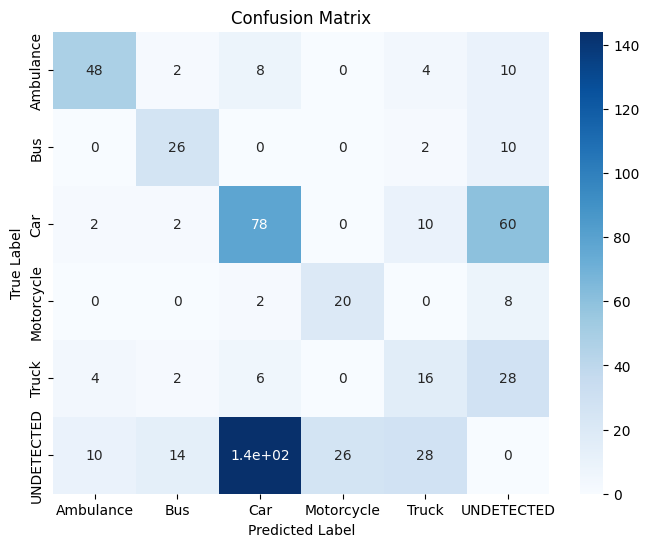

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(results.confusion_matrix.matrix, annot=True, cmap='Blues',
            xticklabels=class_names+['UNDETECTED'], yticklabels=class_names+['UNDETECTED'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Predict Images

Let's try detect object(s) in an image. Here's the step.

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [18]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt source='/content/Cars Detection/test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg'

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/Cars Detection/test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg: 640x640 1 Ambulance, 8.8ms
Speed: 4.0ms preprocess, 8.8ms inference, 544.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


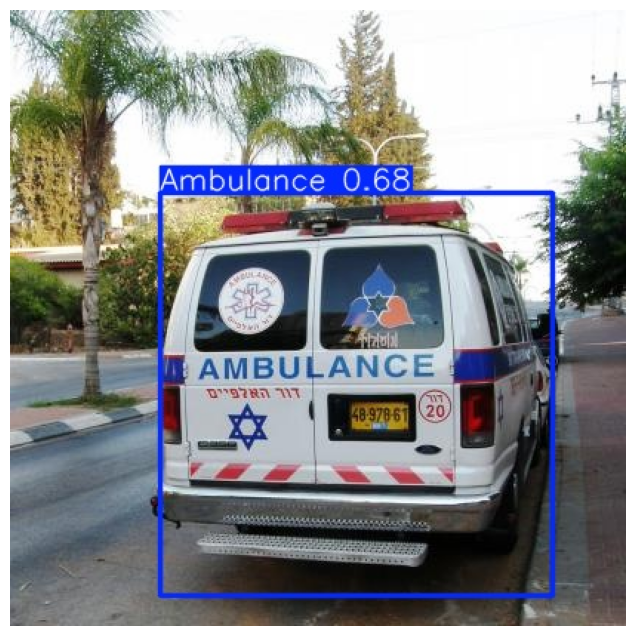

In [19]:
img_path = '/content/runs/detect/predict/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()